In [1]:
## a useful function to generate a data list for further analysis
import os,json,sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sorting_data_pairwise_comparison import calculate_relative_position,generate_points_within_rectangles
import scipy.stats as st

##need to add this additional cell because useful tools are in another folder. Need to integrate these two folders one day
current_working_directory = Path.cwd()
parent_dir = current_working_directory.resolve().parents[0]
sys.path.insert(0, str(parent_dir) + "\\utilities")
from useful_tools import select_animals_gpt,find_file
from data_cleaning import findLongestConseqSubseq

#### Session 0.2: Load analysis methods in python dictionary form

In [2]:
json_file = "./analysis_methods_dictionary.json"
with open(json_file, "r") as f:
    analysis_methods = json.loads(f.read())
    
#Put the folder of your Unity folder below
#thisDataset ="D:/MatrexVR_Swarm_Data/RunData"
#thisDataset ="D:/MatrexVR_blackbackground_Data/RunData"
thisDataset ="D:/MatrexVR_grass1_Data/RunData"
#thisDataset ="D:/MatrexVR_2024_Data/RunData"
#parameter name means independent variable in the experiment
variable_name='mu'
#variable_name='initial_position'
#variable_name='agent_speed'
#check trace in trial 115 from VR1_2024-11-16_155242_score_full, maybe there is a jump

#### Session 1.0: select animals based on condition and return which a directory list and a list of vr rig number to specify which animal to analyse

In [3]:
# Define the path to your Excel file
dir_list = []
file_type=".h5"
using_google_sheet=True
sheet_name = "Unity_MatrexVR"
experiment_name=analysis_methods.get("experiment_name")
# if type(thisDataset) == str:
#     thisDataset = Path(thisDataset)
if analysis_methods.get("load_individual_data") == True:
    if using_google_sheet==True:
        # database_id = "1UL4eEUrQMapx9xz11-IyOSlPBcep3I9vBJ2uGgVudb8"
        #         #https://docs.google.com/spreadsheets/d/1UL4eEUrQMapx9xz11-IyOSlPBcep3I9vBJ2uGgVudb8/edit?usp=sharing
        # url = f"https://docs.google.com/spreadsheets/d/{database_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
        database_id = "1UL4eEUrQMapx9xz11-IyOSlPBcep1I9vBJ2uGgVudb8"
                #https://docs.google.com/spreadsheets/d/1UL4eEUrQMapx9xz11-IyOSlPBcep1I9vBJ2uGgVudb8/edit?usp=sharing
        url = f"https://docs.google.com/spreadsheets/d/{database_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
        #df = pd.read_excel(url, engine='openpyxl')## use this function if the file is not google sheet but uploaded excel file
        df = pd.read_csv(url)
    else:
        excel_file_path = "Z:/DATA/experiment_trackball_Optomotor/Locusts Management.xlsx"
        print(f"using a database {excel_file_path} from the server but this file might be outdated")
        # Create a 'with' statement to open and read the Excel file
        with pd.ExcelFile(excel_file_path) as xls:
            # Read the Excel sheet into a DataFrame with the sheet name (folder name)
            df = pd.read_excel(xls, sheet_name)
        ##list up the conditions and answers as strings for input argument to select animal. One condition must pair with one answer
    if analysis_methods.get("select_animals_by_condition") == True:
       #animal_of_interest=select_animals_gpt(df,"Independent variable (list up all of them in the experiment)","gregarious_leader_grass","Excluding this animal from analysis (Usually when animals die or molt, T/F)","F")
        #animal_of_interest=select_animals_gpt(df,"Independent variable (list up all of them in the experiment)","gregarious_leader_black","Excluding this animal from analysis (Usually when animals die or molt, T/F)","F")
        animal_of_interest=select_animals_gpt(df,"Independent variable1",variable_name,"Excluding this animal from analysis (Usually when animals die or molt, T/F)","F")
        #animal_of_interest=select_animals_gpt(df,"Independent variable1",variable_name,"Independent variable2","choice_vr_locust_black_locust","Excluding this animal from analysis (Usually when animals die or molt, T/F)","F")
        #animal_of_interest=select_animals_gpt(df,"Independent variable1",variable_name,"Independent variable2","choice_vr_locust_sta_black_locust","Background","grass1","Excluding this animal from analysis (Usually when animals die or molt, T/F)","F")
        
        #animal_of_interest=select_animals_gpt(df,"Independent variable1",variable_name,"Independent variable2","closed_loop_sta_black_locust_open_loop_sta_black_locust","Excluding this animal from analysis (Usually when animals die or molt, T/F)","F")
        #animal_of_interest=select_animals_gpt(df,"Independent variable1",variable_name,"Independent variable2","sta_black_locust_2dir_3_initial_position","Excluding this animal from analysis (Usually when animals die or molt, T/F)","F")
    else:
        animal_of_interest=df
    folder_name=animal_of_interest["folder name"].values

    dir_tile=np.tile(thisDataset, (len(folder_name), 1))
    vr_no=animal_of_interest["VR number"].values
    dir_list = [''.join([x[0], '/', y]) for x,y in zip(dir_tile,folder_name)]
    #dir_dict = itertools.zip_longest(dir_list, vr_no.tolist())
    dir_dict = zip(dir_list, vr_no.tolist())
else:
    for root, dirs, files in os.walk(thisDataset):
        for folder in dirs:
            folder_path=os.path.join(root,folder)
            if any(name.endswith(file_type) for name in os.listdir(folder_path)):
                dir_list.append(folder_path.replace("\\", "/"))

In [4]:
dir_list

['D:/MatrexVR_grass1_Data/RunData/20240824_143943',
 'D:/MatrexVR_grass1_Data/RunData/20240824_143943',
 'D:/MatrexVR_grass1_Data/RunData/20240824_143943',
 'D:/MatrexVR_grass1_Data/RunData/20240824_163554',
 'D:/MatrexVR_grass1_Data/RunData/20240824_163554',
 'D:/MatrexVR_grass1_Data/RunData/20240824_184143',
 'D:/MatrexVR_grass1_Data/RunData/20240824_184143',
 'D:/MatrexVR_grass1_Data/RunData/20240824_184143',
 'D:/MatrexVR_grass1_Data/RunData/20240825_132616',
 'D:/MatrexVR_grass1_Data/RunData/20240825_151648',
 'D:/MatrexVR_grass1_Data/RunData/20240825_151648',
 'D:/MatrexVR_grass1_Data/RunData/20240825_170748',
 'D:/MatrexVR_grass1_Data/RunData/20240825_170748',
 'D:/MatrexVR_grass1_Data/RunData/20240825_170748',
 'D:/MatrexVR_grass1_Data/RunData/20240826_131447',
 'D:/MatrexVR_grass1_Data/RunData/20240826_150826',
 'D:/MatrexVR_grass1_Data/RunData/20240826_150826',
 'D:/MatrexVR_grass1_Data/RunData/20240826_150826',
 'D:/MatrexVR_grass1_Data/RunData/20240826_174030',
 'D:/MatrexV

In [ ]:
dir_list=dir_list[32:]
vr_no=vr_no[32:]

In [ ]:
dir_list=dir_list[:32]
vr_no=vr_no[:32]

In [ ]:
dir_list

In [ ]:
len(dir_list)

### Session 1.1: introduce helper functions to make plot and calculate speed

### Section 2.0: Pool animal's response together according to some criteria (from none criteria to criteria that can define the follow behaviour)
Output1: a list 'follow_proportion_across_animals' showing the proportion of 'follow' time for each animal (across trials)

Output2: a list 'relative_pos_all_animals' showing relative position between virtual and focal locusts across time. 1st and 2nd columns shown relative x and y, 3rd columns shown virtual animal's moving direction. 4th column shown the timestamp

In [5]:
analysis_methods.update({"follow_locustVR_criteria": True})

In [ ]:
analysis_methods

In [ ]:
relative_pos_all_animals=[]
simulated_relative_pos_all_animals=[]
trial_evaluation_across_animals=[]
raster_across_animals=[]
animal_id=0
for this_dir,this_vr in zip(dir_list,vr_no):
    if Path(this_dir).is_dir()==False:
        continue
    agent_pattern = f"VR{this_vr}*agent_full.h5"
    xy_pattern = f"VR{this_vr}*XY_full.h5"
    summary_pattern = f"VR{this_vr}*score_full.h5"
    agent_file = find_file(Path(this_dir), agent_pattern)
    focal_animal_file = find_file(Path(this_dir), xy_pattern)
    summary_file = find_file(Path(this_dir), summary_pattern)
    relative_pos,trial_evaluation_list,raster_pd,num_unfilled_gap,simulated_relative_pos=calculate_relative_position(summary_file,focal_animal_file,agent_file,analysis_methods)
    if animal_id==0:
        largest_unfilled_gap=num_unfilled_gap
    elif num_unfilled_gap>largest_unfilled_gap:
        largest_unfilled_gap=num_unfilled_gap
    else:
        pass
    relative_pos_all_animals.append(relative_pos)
    simulated_relative_pos_all_animals.append(simulated_relative_pos)
    trial_evaluation=pd.concat(trial_evaluation_list)
    trial_evaluation.insert(0, 'animal_id',np.repeat(animal_id,trial_evaluation.shape[0]))
    trial_evaluation_across_animals.append(trial_evaluation)
    raster_pd.insert(0, 'animal_id', np.repeat(animal_id,raster_pd.shape[0]))
    raster_across_animals.append(raster_pd)
    animal_id=animal_id+1
analysis_methods['largest_unfilled_gap']= largest_unfilled_gap

In [ ]:
len(trial_evaluation_across_animals)

In [7]:
all_evaluation=pd.concat(trial_evaluation_across_animals)
##for grass background 1 agent
# fair_follower_threshold=0.2
# good_follower_threshold=0.3
##for grass background 2 agent
# fair_follower_threshold=0.1667
# good_follower_threshold=0.25
##for blackground
# fair_follower_threshold=0.05
# good_follower_threshold=0.25

In [ ]:
#1D histogram to show the frequency of following response
fig, axes = plt.subplots(
        nrows=2, ncols=2, figsize=(9,10), tight_layout=True
    )
ax1, ax2, ax3, ax4 = axes.flatten()
follow_time_aba=all_evaluation.groupby(['animal_id'])['num_follow_epochs'].sum()/all_evaluation.groupby(['animal_id'])['number_frames'].sum()
simulated_time_aba=all_evaluation.groupby(['animal_id'])['num_chance_epochs'].sum()/all_evaluation.groupby(['animal_id'])['number_frames'].sum()
follow_time_tbt=all_evaluation['num_follow_epochs']/all_evaluation['number_frames']
simulated_time_tbt=all_evaluation['num_chance_epochs']/all_evaluation['number_frames']
print("first 1/3 best of followers:", np.quantile(follow_time_aba, 0.66))
print("middle 1/3 best of followers:", np.quantile(follow_time_aba, 0.33))
print("first 1/3 best of follow epochs:", np.quantile(follow_time_tbt, 0.66))
print("middle 1/3 best of follow epochs:", np.quantile(follow_time_tbt, 0.33))
print("first 1/3 best of simulated followers:", np.quantile(simulated_time_aba, 0.66))
print("first 1/3 best of simulated epochs:", np.quantile(simulated_time_tbt, 0.66))
fair_follower_threshold=np.quantile(follow_time_aba, 0.33)
good_follower_threshold=np.quantile(follow_time_aba, 0.66)
ax1.hist(follow_time_aba,color='red')
ax1.hist(simulated_time_aba,color='tab:gray',alpha=0.5)
ax1.set(xticks=[0,0.25,0.5,0.75,1],xticklabels=(['0', '25', '50', '75', '100']),xlim=(0,0.5),yticks=[0,20],ylim=(0,20),title='proportion of time following aba')
ax2.hist(follow_time_tbt,color='red',bins=20)
ax2.hist(simulated_time_tbt,color='tab:gray',alpha=0.5,bins=20)
ax2.set(xticks=[0,0.25,0.5,0.75,1],xticklabels=(['0', '25', '50', '75', '100']),xlim=(0,1),title='proportion of time following tbt')
follower_of_interest=all_evaluation.groupby(['animal_id'])['num_follow_epochs'].sum()/all_evaluation.groupby(['animal_id'])['number_frames'].sum()<good_follower_threshold
rows_of_follower=follower_of_interest.repeat(int(all_evaluation.shape[0]/follower_of_interest.shape[0]))
ax3.hist(all_evaluation[rows_of_follower.values]['num_follow_epochs']/all_evaluation[rows_of_follower.values]['number_frames'],density=True)
ax3.set(xticks=[0,0.25,0.5,0.75,1],xlim=(0,1),title='proportion of time from animals below threshold')
follower_of_interest=all_evaluation.groupby(['animal_id'])['num_follow_epochs'].sum()/all_evaluation.groupby(['animal_id'])['number_frames'].sum()>good_follower_threshold
rows_of_follower=follower_of_interest.repeat(int(all_evaluation.shape[0]/follower_of_interest.shape[0]))
ax4.hist(all_evaluation[rows_of_follower.values]['num_follow_epochs']/all_evaluation[rows_of_follower.values]['number_frames'],density=True)
ax4.set(xticks=[0,0.25,0.5,0.75,1],xlim=(0,1),title='proportion of time from animals above threshold')
plt.show()

In [ ]:
##plot the relationship between travel distance and proportion of following time
# print("first 1/3 best of followers:", np.quantile(follow_time_aba, 0.66))
# print("middle 1/3 best of followers:", np.quantile(follow_time_aba, 0.33))
camera_fps=analysis_methods.get("camera_fps")
fair_follower_threshold=np.quantile(follow_time_aba, 0.33)
good_follower_threshold=np.quantile(follow_time_aba, 0.66)
glocust_list=[]
exp_agent_list=[]
fig, axes = plt.subplots(
        nrows=2, ncols=2, figsize=(9,10), tight_layout=True
    )
ax1, ax2, ax3, ax4 = axes.flatten()
ax1.set(xticks=[0,0.25,0.5,0.75,1],xticklabels=(['0', '25', '50', '75', '100']),xlim=(0,0.5))
ax2.set(xticks=[0,0.25,0.5,0.75,1],xticklabels=(['0', '25', '50', '75', '100']),xlim=(0,1))
for keys, this_data in all_evaluation.groupby(['animal_id']):
    p_follow=this_data['num_follow_epochs'].sum()/this_data['number_frames'].sum()
    if p_follow>good_follower_threshold:
        color='k'
    elif (p_follow>fair_follower_threshold) and (p_follow<good_follower_threshold):
        color='k'
    else:
        color='k'
    ax1.scatter(this_data['num_follow_epochs'].sum()/this_data['number_frames'].sum(),this_data['travel_distance'].sum()/camera_fps,c=color,s=8)
    ax3.scatter(this_data['num_follow_epochs'].sum()/this_data['number_frames'].sum(),this_data['turning_distance'].sum()/camera_fps,c=color,s=8)
    # if p_follow>good_follower_threshold:
    #     pass
    # elif (p_follow>fair_follower_threshold) and (p_follow<good_follower_threshold):
    #     pass
    # else:
    #     continue

    for this_object in this_data['object'].unique():
        these_num_follow_epochs=this_data['num_follow_epochs'][this_data['object']==this_object]
        these_num_frames=this_data['number_frames'][this_data['object']==this_object]
        these_travel_distance=this_data['travel_distance'][this_data['object']==this_object]
        these_turning_distance=this_data['turning_distance'][this_data['object']==this_object]
        if this_object=='mov_glocust' or this_object== "LeaderLocust":
            # ax2.scatter(these_num_follow_epochs/these_num_frames,these_travel_distance,c=color,s=8)
            # ax4.scatter(these_num_follow_epochs/these_num_frames,these_turning_distance,c=color,s=8)
            ax2.scatter(these_num_follow_epochs/these_num_frames,these_travel_distance,c='b',s=8)
            ax4.scatter(these_num_follow_epochs/these_num_frames,these_turning_distance,c='b',s=8)
            follow_time_ratio_tbt=these_num_follow_epochs/these_num_frames
            glocust_list.append(follow_time_ratio_tbt.values)
        else:
            # ax2.scatter(these_num_follow_epochs/these_num_frames,these_travel_distance,edgecolors=color,marker='o', facecolors='none',s=8)
            # ax4.scatter(these_num_follow_epochs/these_num_frames,these_turning_distance,edgecolors=color,marker='o', facecolors='none',s=8)
            ax2.scatter(these_num_follow_epochs/these_num_frames,these_travel_distance,c='r',s=8)
            ax4.scatter(these_num_follow_epochs/these_num_frames,these_turning_distance,c='r',s=8)
            follow_time_ratio_tbt=these_num_follow_epochs/these_num_frames
            exp_agent_list.append(follow_time_ratio_tbt.values)
ax3.set(xticks=[0,0.25,0.5,0.75,1],xticklabels=(['0', '25', '50', '75', '100']),xlim=(0,0.5))
ax4.set(xticks=[0,0.25,0.5,0.75,1],xticklabels=(['0', '25', '50', '75', '100']),xlim=(0,1))
plt.show()

In [12]:
all_evaluation['batchs'] = pd.cut(all_evaluation['animal_id'], bins=3, labels=['1st', '2nd', '3rd'])

C:\Users\neuroLaptop\AppData\Local\Temp\ipykernel_3292\2344363941.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for keys, grp in all_evaluation.groupby(['batchs']):


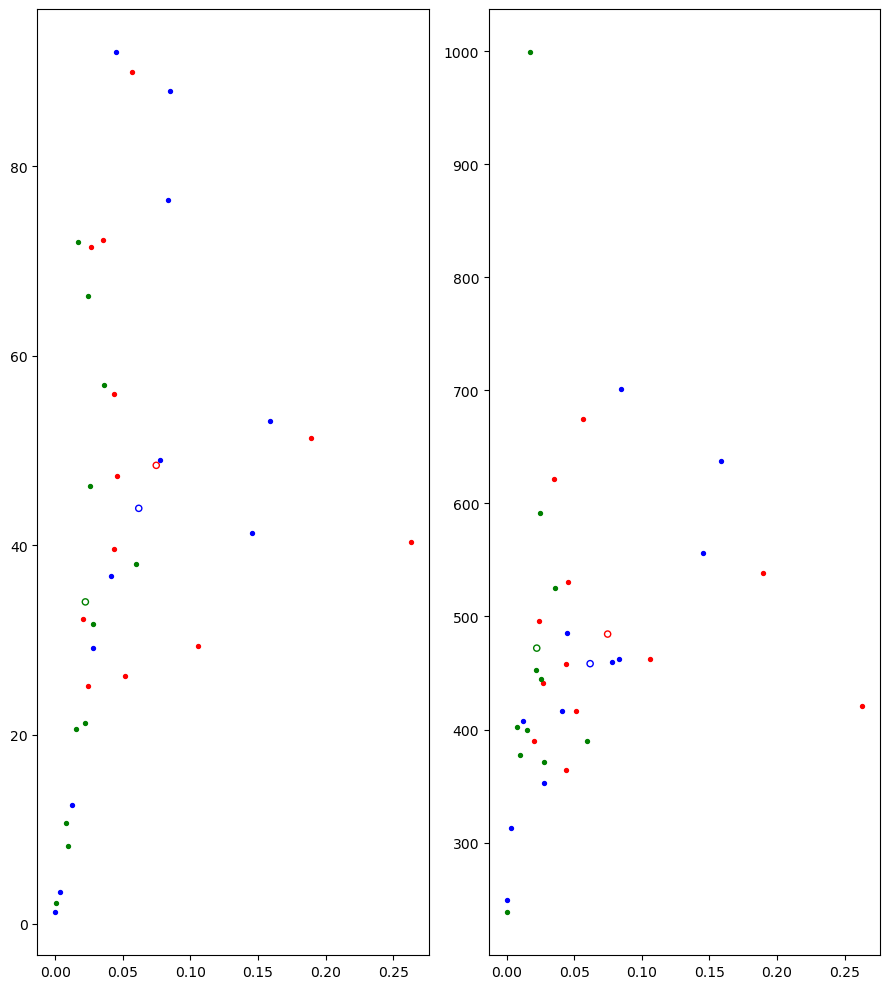

In [33]:
colors = ['red', 'blue', 'green']
camera_fps=analysis_methods.get("camera_fps")
fig, axes = plt.subplots(
        nrows=1, ncols=2, figsize=(9,10), tight_layout=True
    )
ax1, ax2 = axes.flatten()
for keys, grp in all_evaluation.groupby(['animal_id']):
    if grp['batchs'].values[0]=='1st':
        this_color=colors[0]
    elif grp['batchs'].values[0]=='2nd':
        this_color=colors[1]
    else:
        this_color=colors[2]
    travel_distance=grp['travel_distance'].sum()/camera_fps
    turning_distance=grp['turning_distance'].sum()/camera_fps
    num_follow_epochs=grp['num_follow_epochs'].sum()/grp['number_frames'].sum()
    ax1.scatter(grp['num_follow_epochs'].sum()/grp['number_frames'].sum(),grp['travel_distance'].sum()/camera_fps,c=this_color,s=8)
    ax2.scatter(grp['num_follow_epochs'].sum()/grp['number_frames'].sum(),grp['turning_distance'].sum()/camera_fps,c=this_color,s=8)
for keys, grp in all_evaluation.groupby(['batchs']):
    if grp['batchs'].values[0]=='1st':
        this_color=colors[0]
    elif grp['batchs'].values[0]=='2nd':
        this_color=colors[1]
    else:
        this_color=colors[2]
    ax1.scatter(grp['num_follow_epochs'].sum()/grp['number_frames'].sum(),grp['travel_distance'].sum()/camera_fps/grp['animal_id'].unique().shape[0],edgecolors=this_color,s=20,facecolors='none')
    ax2.scatter(grp['num_follow_epochs'].sum()/grp['number_frames'].sum(),grp['turning_distance'].sum()/camera_fps/grp['animal_id'].unique().shape[0],edgecolors=this_color,s=20,facecolors='none')

In [30]:
#chop the data into 3 groups depends on time. Then we can analyse the 1st, 2nd and 3rd of the data
all_evaluation['time_group'] = pd.cut(all_evaluation['trial_id'], bins=3, labels=['1st', '2nd', '3rd'])

In [ ]:
num_follow_list=[]
travel_distance_list=[]
for keys, grp in all_evaluation.groupby(['animal_id','time_group']):
    num_follow_list.append(grp["num_follow_epochs"].sum())
    travel_distance_list.append(grp["travel_distance"].sum())
num_follow_arr=np.array(num_follow_list).reshape(-1,3)
travel_distance_arr=np.array(travel_distance_list).reshape(-1,3)

In [ ]:
fig, axes = plt.subplots(
        nrows=1, ncols=2, figsize=(9,10), tight_layout=True
    )
ax1, ax2 = axes.flatten()
ax1.plot(np.transpose(num_follow_arr), 'o-')
ax1.plot(np.mean(num_follow_arr,axis=0),'k',linewidth=5)
ax1.plot(np.median(num_follow_arr,axis=0),'k',linewidth=5,alpha=0.6)
ax2.plot(np.transpose(travel_distance_arr), 'o-')
ax2.plot(np.mean(travel_distance_arr,axis=0),'k',linewidth=5)
ax2.plot(np.median(travel_distance_arr,axis=0),'k',linewidth=5,alpha=0.6)

In [ ]:
def summarise_as_csv(input_list,agent_type='glocust'):
    df=pd.DataFrame(np.hstack(input_list))
    df.insert(0, 'agent_type', np.repeat(agent_type,df.shape[0]).tolist())
    df.insert(0, 'ID', np.repeat(np.arange(len(input_list)),int(df.shape[0]/len(input_list))).tolist())
    df.to_csv(f'{agent_type}.csv')

In [ ]:
summarise_as_csv(exp_agent_list,'exp_agent')

In [ ]:
summarise_as_csv(exp_agent_list)

#### Section 2.1: Using 1D histogram to plot proportion of time and 2D histogram to plot relative position

In [35]:
all_trials=pd.concat(relative_pos_all_animals)
all_simulated_trials=pd.concat(simulated_relative_pos_all_animals)

In [ ]:
extract_follow_epoches=analysis_methods.get("extract_follow_epoches",True)
distribution_with_entire_body=analysis_methods.get("distribution_with_entire_body",True)
fig, axes = plt.subplots(nrows=1, ncols=len(all_trials["type"].unique())*len(all_trials["degree"].unique()),figsize=(18, 6),tight_layout=True,sharex=True, sharey=True)
i=0
if extract_follow_epoches:
    xlimit=(-5,40)
    ylimit=(-15,15)
else:
    xlimit=(-20,100)
    ylimit=(-45,45)
for keys, grp in all_trials.groupby(['type','degree']):
        print(keys)
        if distribution_with_entire_body:
            body_points=generate_points_within_rectangles(grp['x'].values,grp['y'].values,1,4,2,21)
            axes[i].hist2d(body_points[:,0],body_points[:,1],bins=1000)
        else:
            axes[i].hist2d(grp['x'].values,grp['y'].values,bins=400)
        axes[i].set(
        yticks=[ylimit[0],0,ylimit[1]],
        xticks=[-5,0,4,20,40],
        xlim=xlimit,ylim=ylimit,title=f'agent:{keys[0]},deg:{int(keys[1])}',adjustable='box', aspect='equal')
        #rect = patches.Rectangle((0,-1), 6, 2, linewidth=1, edgecolor='red',linestyle="--",facecolor='none')
        #cir1 = patches.Circle((4,0), radius=0.5, linewidth=0.5, edgecolor='yellow')
        cir2 = patches.Circle((0,0), radius=0.4, linewidth=0.4, edgecolor='red',facecolor='red')
        #axes[i].add_patch(cir1)
        axes[i].add_patch(cir2)
        i=i+1
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=len(all_simulated_trials["type"].unique())*len(all_simulated_trials["degree"].unique()),figsize=(18, 6),tight_layout=True,sharex=True, sharey=True)
i=0
if extract_follow_epoches:
    xlimit=(-5,40)
    ylimit=(-15,15)
else:
    xlimit=(-20,100)
    ylimit=(-45,45)
for keys, grp in all_simulated_trials.groupby(['type','degree']):
        if distribution_with_entire_body:
            body_points=generate_points_within_rectangles(grp['x'].values,grp['y'].values,1,4,2,21)
            axes[i].hist2d(body_points[:,0],body_points[:,1],bins=1000)
        else:
            axes[i].hist2d(grp['x'].values,grp['y'].values,bins=400)
        axes[i].set(
        yticks=[ylimit[0],0,ylimit[1]],
        xticks=[-5,0,4,20,40],
        xlim=xlimit,ylim=ylimit,title=f'agent:{keys[0]},deg:{int(keys[1])}',adjustable='box', aspect='equal')
        #rect = patches.Rectangle((0,-1), 6, 2, linewidth=1, edgecolor='red',linestyle="--",facecolor='none')
        #cir1 = patches.Circle((4,0), radius=0.5, linewidth=0.5, edgecolor='yellow')
        cir2 = patches.Circle((0,0), radius=0.4, linewidth=0.4, edgecolor='red',facecolor='red')
        #axes[i].add_patch(cir1)
        axes[i].add_patch(cir2)
        i=i+1
plt.show()

In [ ]:
##plot the distribution of follow epochs in a trial
for keys, grp in all_trials.groupby(['type','degree']):
    sim_grp=all_simulated_trials[(all_simulated_trials['type']==keys[0])&(all_simulated_trials['degree']==keys[1])]
    print(keys)
    fig, axes = plt.subplots(
        nrows=1, ncols=2, figsize=(9,5), tight_layout=True
    )
    ax, ax2 = axes.flatten()
    ax.hist(grp['ts'].values,bins=100,density=False,color='r')
    ax.hist(sim_grp['ts'].values,bins=100,density=False,color='tab:gray',alpha=0.3)
    ax2.hist(grp['ts'].values,bins=100,color='r',density=True,histtype="step",cumulative=True,label="Cumulative histogram")
    ax2.hist(sim_grp['ts'].values,bins=100,color='tab:gray',alpha=0.3,density=True,histtype="step",cumulative=True,label="Cumulative histogram")
    ax.set(xlim=(0,60),title=f'agent:{keys[0]},deg:{int(keys[1])}')

plt.show()

In [8]:
from scipy.optimize import curve_fit
#https://stackoverflow.com/questions/78384537/fitting-2d-histograms-with-2d-gaussians
def twoD_Gaussian(xy, amplitude, xo, yo, sigma_x, sigma_y, rho):
    x, y = xy
    xo = float(xo)
    yo = float(yo)
    a = 1 / sigma_x ** 2
    b = rho / sigma_x / sigma_y
    c = 1 / sigma_y ** 2
    exponent=  - (1 / (2 * (1 - rho ** 2)))\
                 * (a * (x - xo) ** 2 - 2 * b * (x - xo) * (y - yo) + c * (y - yo) ** 2)
    g = amplitude * np.exp(exponent)
    return g.ravel()

In [92]:
nbr_bins = 100
B, xedges, yedges = np.histogram2d(grp['x'].values,grp['y'].values, bins=nbr_bins)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
bin_centers_bx = (xedges[:-1] + xedges[1:]) / 2.0
bin_centers_by = (yedges[:-1] + yedges[1:]) / 2.0
X, Y = np.meshgrid(bin_centers_bx, bin_centers_by)
data = B.ravel()

In [ ]:
mean = [0, 4]
p0 = (B.max(),mean[0],mean[1],1.7,1.0,0.9)
coeff, var_matrix = curve_fit(twoD_Gaussian, (X, Y), data, p0=p0)
print('hist fit', coeff)
print('var_matrix', var_matrix)
data_fitted_hist = twoD_Gaussian((X, Y), *coeff)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

xlimit=(-30,30)
ylimit=(-30,30)
ax[0].imshow(data.reshape((nbr_bins, nbr_bins)), origin="lower",
             extent=extent, interpolation="none")
ax[1].imshow(data.reshape((nbr_bins, nbr_bins)), origin="lower",
             extent=extent, interpolation="none")
ax[1].contour(X, Y, data_fitted_hist.reshape(nbr_bins, nbr_bins), 2, colors="w",linestyles='dashed',linewidths=0.5)
ax[0].set(
        yticks=[-30,0.0,30],
        xticks=[-30,0.0,30],
        xlim=xlimit,ylim=ylimit)
ax[1].set(
        yticks=[-30,0.0,30],
        xticks=[-30,0.0,30],
        xlim=xlimit,ylim=ylimit)

In [ ]:
analysis_methods.update({"distribution_with_entire_body": True})

In [ ]:
##plot the spatial distribution of virtual locusts in a 2D histogram

distribution_with_entire_body=analysis_methods.get("distribution_with_entire_body",True)
xlimit=(-30,30)
ylimit=(-30,30)
for keys, grp in all_trials.groupby(['type']):
    fig, ax = plt.subplots(dpi=300, figsize=(2,2))
    if distribution_with_entire_body:
        body_points=generate_points_within_rectangles(grp['x'].values,grp['y'].values,1,4,2,21)
        ax.hist2d(body_points[:,0],body_points[:,1],bins=1000)
    else:
        ax.hist2d(grp['x'].values,grp['y'].values,bins=100)
    ax.set(adjustable='box', aspect='equal')
    ax.set(
        yticks=[-30,0.0,30],
        xticks=[-30,0.0,30],
        xticklabels=(['-0.3', '0.0', '0.3']),
        yticklabels=(['-0.3', '0.0', '0.3']),
        xlim=xlimit,ylim=ylimit,title=f'agent:{keys[0]}')
    '''
    the position of virtual locust if their butt is at the origin
    rect = patches.Rectangle((0,-1), 6, 2, linewidth=1, edgecolor='red',linestyle="--",facecolor='none')
    ax.add_patch(rect)
    '''
    cir = patches.Circle((0,0), radius=0.5, linewidth=0.5, edgecolor='red')
    ax.add_patch(cir)
plt.show()

In [ ]:
##plot the temporal distribution of follow epochs in a trial
for keys, grp in all_trials.groupby(['type']):
    print(keys)
    sim_grp=all_simulated_trials[all_simulated_trials['type']==keys[0]]
    fig, axes = plt.subplots(
        nrows=1, ncols=2, figsize=(9,5), tight_layout=True
    )
    ax, ax2 = axes.flatten()
    ax.hist(grp['ts'].values,bins=100,density=False,color='r')
    ax.hist(sim_grp['ts'].values,bins=100,density=False,color='tab:gray',alpha=0.5)
    ax2.hist(grp['ts'].values,bins=100,density=True,color='r',histtype="step",cumulative=True,label="Cumulative histogram")
    ax2.hist(sim_grp['ts'].values,bins=100,color='tab:gray',alpha=0.5,density=True,histtype="step",cumulative=True,label="Cumulative histogram")
    ax.set(xlim=(0,60))
plt.show()

#### Section 2.2: save data into Mat file if needed

In [ ]:
##save the raw data into mat file for matlab
from scipy.io import savemat
all_raw=pd.concat(relative_pos_all_animals)
#all_raw['trial_id']=all_raw['trial_id'].astype(int)
data_dict = {name: col.values for name, col in all_raw.items()}
summary_file_name = Path(thisDataset) /"time_series_curated.mat"
savemat(summary_file_name, data_dict)

### Section 3.0, analysis walking behavours before and after the presence of stimulus

In [11]:
def fix_data_type(all_trials):
    all_trials['id'] = all_trials['id'].astype(int)
    all_trials['mu'] = all_trials['mu'].astype(int)
    all_trials['velocity'] = all_trials['velocity'].astype(float)
    all_trials['omega'] = all_trials['omega'].astype(float)
    all_trials['normalised_v'] = all_trials['normalised_v'].astype(float)
    all_trials['normalised_omega'] = all_trials['normalised_omega'].astype(float)
    if 'density' in all_trials.columns:
        all_trials['density'] = all_trials['density'].astype(int)
    return all_trials

In [12]:
if type(raster_across_animals)==list:
    all_trials=pd.concat(raster_across_animals)
    all_trials=fix_data_type(all_trials)
else:
    all_trials=fix_data_type(raster_across_animals)

In [13]:
def check_baseline_distribution(all_trials,analysis_methods,metrics_name='velocity',duration_for_baseline=3):
    monitor_fps=analysis_methods.get("monitor_fps")
    align_with_isi_onset=analysis_methods.get("align_with_isi_onset",False)
    these_baselines=[]
    for keys, this_data in all_trials.groupby(['animal_id','id']):
        #print(this_data['object'][1])
        if align_with_isi_onset:
            if this_data['object'][1]!='empty_trial':
            #if keys[1]%2==0:#for the Swarm scene to only use stim trials to get the baseline
                this_metrics=this_data[metrics_name].values
                #print(this_metrics)
                these_baselines.append(np.mean(this_metrics[-duration_for_baseline*monitor_fps:]))
        
        else:
            if this_data['object'][1]=='empty_trial':
            #if keys[1]%2!=0:#for the Swarm scene to only use ISI trials
                this_metrics=this_data[metrics_name].values
                these_baselines.append(np.mean(this_metrics[-duration_for_baseline*monitor_fps:]))
    fig, axes = plt.subplots(
        nrows=1, ncols=1, figsize=(9,9), tight_layout=True
    )
    axes.hist(np.vstack(these_baselines),bins=500)
    if metrics_name=='velocity':
        axes.set(xlim=(0,10),ylim=(0, 250))
    else:
        #axes.set(xlim=(-0.001,0.001),ylim=(0, 60))#if used rad
        axes.set(xlim=(-3,3),ylim=(0, 400))

    plt.minorticks_on()
    plt.show()

In [ ]:
metrics_name='omega'
check_baseline_distribution(all_trials,analysis_methods,metrics_name,3)
# check_baseline_distribution(all_trials,analysis_methods)

In [15]:
def split_trials(analysis_methods,all_trials,metrics_name='velocity',metrics_name2='normalised_v',walk_threshold=1,duration_for_baseline=3):
    monitor_fps=analysis_methods.get("monitor_fps")
    movement_trial_boolean=[]
    these_metrics=[]
    these_normalised_metrics=[]
    for keys, this_data in all_trials.groupby(['animal_id','id']):
        this_metrics=this_data[metrics_name].values
        baseline_metrics=np.mean(this_metrics[-duration_for_baseline*monitor_fps:])
        movement_trial_boolean.append(abs(baseline_metrics)>walk_threshold)
        these_metrics.append(this_metrics)
        these_normalised_metrics.append(this_data[metrics_name2].values)
    return movement_trial_boolean,these_metrics,these_normalised_metrics

In [16]:
#for simplicity, classifying trial only based on stationary and walk trails
metrics_name='omega'
_,these_metrics,these_normalised_metrics=split_trials(analysis_methods,all_trials,metrics_name,'normalised_omega',1)#1 degree or 0.0002 rad
movement_trial_boolean,_,_=split_trials(analysis_methods,all_trials)

In [51]:
#movement_trial_boolean,these_metrics,these_normalised_metrics=split_trials(analysis_methods,all_trials)

In [17]:
def extract_trial_index(movement_trial_boolean,analysis_methods):
    align_with_isi_onset=analysis_methods.get("align_with_isi_onset",False)
#int((trial_id)/2) means the number of stimulus trial
    after_movement_ith_trial=[]
    after_no_movement_ith_trial=[]
    if align_with_isi_onset:
        after_movement_ith_trial=[i+1 for i, x in enumerate(movement_trial_boolean[1::2]) if x and i % int((trial_id)/2) != (trial_id)/2-1]
        after_no_movement_ith_trial=[i+1 for i, x in enumerate(movement_trial_boolean[1::2]) if x==False and i % int((trial_id)/2) != (trial_id)/2-1]
    else:
        after_movement_ith_trial=[i for i, x in enumerate(movement_trial_boolean[::2]) if x]
        after_no_movement_ith_trial=[i for i, x in enumerate(movement_trial_boolean[::2]) if x==False]
    return after_movement_ith_trial,after_no_movement_ith_trial

In [18]:
after_movement_ith_trial,after_no_movement_ith_trial=extract_trial_index(movement_trial_boolean,analysis_methods)

In [19]:
def get_fill_between_range(data,mean_data,using_confidence_interval=True):

    ##to plot distribution with 95% confidence interval with t distribution (since the sample is usually not big)
    if using_confidence_interval:
        confidence_level = 0.95
        #cl95=st.t.interval(confidence=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data)) 
        cl95=st.norm.interval(confidence_level,loc=mean_data,scale=st.sem(data))
        dif_y1=cl95[0][:]
        dif_y2=cl95[1][:]
    else:
        sem_response = np.std(data, axis=0, ddof=1) / np.sqrt(data.shape[0])
        dif_y1=mean_data + sem_response
        dif_y2=mean_data - sem_response
    return dif_y1,dif_y2

In [20]:
def plot_visual_evoked_behaviour(these_metrics,these_normalised_metrics,after_movement_ith_trial,after_no_movement_ith_trial,analysis_methods,metrics_name='velocity',row_of_interest=None,type_key="",variable_values=None):
    exp_name=analysis_methods.get('experiment_name')
    number_frame_scene_changing=analysis_methods.get("largest_unfilled_gap",12)
    number_frame_scene_changing=10#set an arbitrary value to escape from the effect of missing value when plotting the histogram
    align_with_isi_onset=analysis_methods.get("align_with_isi_onset",False)
    save_output=analysis_methods.get("save_output",False)
    analysis_window=analysis_methods.get("analysis_window")
    monitor_fps=analysis_methods.get("monitor_fps")
    camera_fps=analysis_methods.get("camera_fps")
    all_animals=False
    tmp=np.vstack(these_metrics)
    tmp3=np.vstack(these_normalised_metrics)
    if align_with_isi_onset:
       stim_evoked_metrics=tmp[::2]
       stim_evoked_norm_metrics=tmp3[::2]
    else:
       stim_evoked_metrics=tmp[1::2]
       stim_evoked_norm_metrics=tmp3[1::2]

    fig, axes = plt.subplots(
            nrows=4, ncols=2, figsize=(9,10), tight_layout=True
        )
    ax1, ax2, ax3, ax4,ax5,ax6,ax7,ax8 = axes.flatten()
    plt.rcParams.update(plt.rcParamsDefault)
    plt.rcParams.update({'font.size': 8})
    # Set the axis line width to 2
    plt.rcParams['ytick.major.width'] = 1
    plt.rcParams['xtick.major.width'] = 1
    plt.rcParams['axes.linewidth'] = 1
    cmap = plt.get_cmap('viridis')
    if all_animals==False and type(row_of_interest)==pd.Series:
        animal_interest_stationary=[]
        animal_interest_move=[]
        for i in np.where(row_of_interest)[0].tolist():
            if i in after_no_movement_ith_trial:
                animal_interest_stationary.append(i)
            else:
                animal_interest_move.append(i)
        p3=stim_evoked_metrics[animal_interest_stationary,:]
        p4=stim_evoked_metrics[animal_interest_move,:]
        p5=stim_evoked_norm_metrics[animal_interest_stationary,:]
        p6=stim_evoked_norm_metrics[animal_interest_move,:]

    else:
        p3=stim_evoked_metrics[after_no_movement_ith_trial,:]
        p4=stim_evoked_metrics[after_movement_ith_trial,:]
        p5=stim_evoked_norm_metrics[after_no_movement_ith_trial,:]
        p6=stim_evoked_norm_metrics[after_movement_ith_trial,:]
    x=np.arange(0,p3.shape[1])
    p1=np.nancumsum(p3, axis=1)/camera_fps
    p2=np.nancumsum(p4, axis=1)/camera_fps
    ax1.plot(np.transpose(p1),linewidth=0.1)
    mean_p1=np.nanmean(p1,axis=0)
    ax1.plot(mean_p1,'k',linewidth=1)
    #ax1.plot(np.nanmedian(p1,axis=0),'k--',linewidth=0.5)
    dif_y1,dif_y2=get_fill_between_range(p1,mean_p1)
    ax1.fill_between(x,dif_y1,dif_y2, alpha=0.4,color='k')
    ax2.plot(np.transpose(p2),linewidth=0.1)
    mean_p2=np.nanmean(p2,axis=0)

    ax2.plot(mean_p2,'k',linewidth=1)
    #ax2.plot(np.nanmedian(p2,axis=0),'k--',linewidth=0.5)
    dif_y1,dif_y2=get_fill_between_range(p2,mean_p2)
    ax2.fill_between(x,dif_y1,dif_y2, alpha=0.4,color='k')
    ax3.plot(np.transpose(p3),linewidth=0.1)
    mean_p3=np.nanmean(p3,axis=0)
    ax3.plot(mean_p3,'k',linewidth=1)
    dif_y1,dif_y2=get_fill_between_range(p3,mean_p3)
    ax3.fill_between(x,dif_y1,dif_y2, alpha=0.4,color='k')
    #ax3.plot(np.nanmedian(p3,axis=0),'k--',linewidth=0.5)
    mean_p4=np.nanmean(p4,axis=0)
    dif_y1,dif_y2=get_fill_between_range(p4,mean_p4)
    ax4.plot(np.transpose(p4),linewidth=0.1)
    ax4.plot(mean_p4,'k',linewidth=1)
    ax4.fill_between(x,dif_y1,dif_y2, alpha=0.4,color='k')
    #ax4.plot(np.nanmedian(p4,axis=0),'k--',linewidth=0.5)
    mean_p5=np.nanmean(p5,axis=0)
    dif_y1,dif_y2=get_fill_between_range(p5,mean_p5)
    ax5.plot(np.transpose(p5),linewidth=0.1)
    ax5.plot(mean_p5,'k',linewidth=1)
    ax5.fill_between(x,dif_y1,dif_y2, alpha=0.4,color='k')
    #ax5.plot(np.nanmedian(p5,axis=0),'k--',linewidth=0.5)
    mean_p6=np.nanmean(p6,axis=0)
    dif_y1,dif_y2=get_fill_between_range(p6,mean_p6)
    ax6.plot(np.transpose(p6),linewidth=0.1)
    ax6.plot(mean_p6,'k',linewidth=1)
    ax6.fill_between(x,dif_y1,dif_y2,alpha=0.4,color='k')

    #ax6.plot(np.nanmedian(p6,axis=0),'k--',linewidth=0.5)
    if metrics_name=='velocity' and all_animals==False:
        ylimit=10
        ylimit_log=100
        ax1.set_ylim([0,5*ylimit])
        ax2.set_ylim([0,5*ylimit])
        ax3.set_ylim([0,1*ylimit])
        ax4.set_ylim([0,1*ylimit])
    elif all_animals==False:
        ylimit=80
        ylimit_log=1000
        # ax1.yaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
        # ax1.yaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
        # ax2.yaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
        # ax2.yaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
        # ax3.yaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
        # ax3.yaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
        # ax4.yaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
        # ax4.yaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
        ax1.set_ylim([-1*ylimit,1*ylimit])
        ax2.set_ylim([-1*ylimit,1*ylimit])
        ax3.set_ylim([-1*ylimit,1*ylimit])
        ax4.set_ylim([-1*ylimit,1*ylimit])
    elif metrics_name=='velocity':
        ylimit=10
        ylimit_log=100
        ax1.set_ylim([0,5*ylimit])
        ax2.set_ylim([0,5*ylimit])
        ax3.set_ylim([0,1*ylimit])
        ax4.set_ylim([0,1*ylimit])
    else:
        ylimit=80
        ylimit_log=1000
        # ax1.yaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
        # ax1.yaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
        # ax2.yaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
        # ax2.yaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
        # ax3.yaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
        # ax3.yaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
        # ax4.yaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
        # ax4.yaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
        ax1.set_ylim([-1*ylimit,1*ylimit])
        ax2.set_ylim([-1*ylimit,1*ylimit])
        ax3.set_ylim([-1*ylimit,1*ylimit])
        ax4.set_ylim([-1*ylimit,1*ylimit])
    ax1.set(
        ylabel=f"sum of {metrics_name}",
        #xlabel="frame",
        xlabel="Time (s)",
        xticks=[0,analysis_window[1]*monitor_fps],
        xticklabels=(['0', str(analysis_window[1])]),
    )
    ax2.set(
        ylabel=f"sum of {metrics_name}",
        #xlabel="frame",
        xlabel="Time (s)",
        xticks=[0,analysis_window[1]*monitor_fps],
        xticklabels=(['0', str(analysis_window[1])]),
    )
    ax3.set(
        ylabel=metrics_name,
        #xlabel="frame",
        xlabel="Time (s)",
        xticks=[0,analysis_window[1]*monitor_fps],
        xticklabels=(['0', str(analysis_window[1])]),
    )
    ax4.set(
        ylabel=metrics_name,
        #xlabel="frame",
        xlabel="Time (s)",
        xticks=[0,analysis_window[1]*monitor_fps],
        xticklabels=(['0', str(analysis_window[1])]),
    )
    ax5.set(
        ylabel="normalised values (ratio)",
        xlabel="frame",
        ylim=[1/ylimit_log,ylimit_log],
    )
    ax6.set(
        ylabel="normalised values (ratio)",
        xlabel="frame",
        ylim=[1/ylimit_log,ylimit_log],
    )
    # if metrics_name=='velocity':
    #     peak_distribution_stationary=np.argmax(p3, axis=1)
    #     peak_distribution_move=np.argmax(p4, axis=1)
    # else:
    peak_distribution_stationary=np.argmax(abs(p3[:,number_frame_scene_changing:]), axis=1)
    peak_distribution_stationary=peak_distribution_stationary+number_frame_scene_changing
    
    #print(peak_distribution_stationary.shape)
    peak_distribution_move=np.argmax(abs(p4[:,number_frame_scene_changing:]), axis=1)
    peak_distribution_move=peak_distribution_move+number_frame_scene_changing
    #print(peak_distribution_move.shape)
    ax5.set_yscale('log')
    ax6.set_yscale('log')
    ax7.hist(abs(peak_distribution_stationary),bins=10)
    ax7.set(
        ylabel="Count",
        xlabel="Time (s)",
        xticks=[0,analysis_window[1]*monitor_fps],
        xticklabels=(['0', str(analysis_window[1])]),
    )
    ax8.hist(abs(peak_distribution_move),bins=10)
    ax8.set(
        ylabel="Count",
        xlabel="Time (s)",
        xticks=[0,analysis_window[1]*monitor_fps],
        xticklabels=(['0', str(analysis_window[1])]),
    )
    if save_output==True:
        fig_name=f"ts_plot_{exp_name}_{variable_values}_{metrics_name}_{type_key}.png"
        fig.savefig(fig_name)
    plt.show()

In [ ]:
analysis_methods.update({"save_output": True})

In [34]:
##criteria to sort out data from good followers
# fair_follower_threshold=0.20
#fair_follower_threshold=0.1667
# good_follower_threshold=0.3
#data from grass1 secene
# first 1/3 best of followers: 0.04542389707280022
# middle 1/3 best of followers: 0.024365961537554066
use_follower_threshold=True
if use_follower_threshold==True:
    p_follow=all_evaluation.groupby(['animal_id'])['num_follow_epochs'].sum()/all_evaluation.groupby(['animal_id'])['number_frames'].sum()
    #follower_of_interest=p_follow>good_follower_threshold
    #follower_of_interest=(p_follow>fair_follower_threshold) & (p_follow<good_follower_threshold)
    follower_of_interest=p_follow>0.025
    #rows_of_follower=follower_of_interest.repeat(int(all_evaluation.shape[0]/follower_of_interest.shape[0]))
else:
    #good_trial_threshold=0.125
    good_trial_threshold=0.125
    long_following_epochs=all_evaluation['num_follow_epochs']/all_evaluation['number_frames']>good_trial_threshold

In [ ]:
# if all_evaluation['object'].unique().shape[0]>1:
for type_key in all_evaluation['radial_distance'].unique():
    print(type_key)
    rows_of_follower=follower_of_interest.repeat(int(all_evaluation.shape[0]/follower_of_interest.shape[0]))
    for this_condition in all_evaluation['mu'].unique():
        print(this_condition)
        if use_follower_threshold==True:
            row_of_interest=(all_evaluation['mu'].reset_index(drop=True)==this_condition)&(all_evaluation['radial_distance'].reset_index(drop=True)==type_key) &(rows_of_follower.reset_index(drop=True))
        else:
            row_of_interest=(all_evaluation['mu'].reset_index(drop=True)==this_condition)&(all_evaluation['radial_distance'].reset_index(drop=True)==type_key)&(long_following_epochs.reset_index(drop=True))
        plot_visual_evoked_behaviour(these_metrics,these_normalised_metrics,after_movement_ith_trial,after_no_movement_ith_trial,analysis_methods,metrics_name,row_of_interest,type_key,this_condition)

In [ ]:
# if all_evaluation['object'].unique().shape[0]>1:
for type_key in all_evaluation['object'].unique():
    print(type_key)
    rows_of_follower=follower_of_interest.repeat(int(all_evaluation.shape[0]/follower_of_interest.shape[0]))
    for this_condition in all_evaluation['mu'].unique():
        print(this_condition)
        if use_follower_threshold==True:
            row_of_interest=(all_evaluation['mu'].reset_index(drop=True)==this_condition)&(all_evaluation['object'].reset_index(drop=True)==type_key) &(rows_of_follower.reset_index(drop=True))
        else:
            row_of_interest=(all_evaluation['mu'].reset_index(drop=True)==this_condition)&(all_evaluation['object'].reset_index(drop=True)==type_key)&(long_following_epochs.reset_index(drop=True))
        plot_visual_evoked_behaviour(these_metrics,these_normalised_metrics,after_movement_ith_trial,after_no_movement_ith_trial,analysis_methods,metrics_name,row_of_interest,type_key,this_condition)

In [ ]:
movement_trial_boolean,these_metrics,these_normalised_metrics=split_trials(analysis_methods,all_trials)

In [ ]:
metrics_name='velocity'
for type_key in all_evaluation['object'].unique():
    print(type_key)
    rows_of_follower=follower_of_interest.repeat(int(all_evaluation.shape[0]/follower_of_interest.shape[0]))
    for this_condition in all_evaluation['mu'].unique():
        print(this_condition)
        if use_follower_threshold==True:
            row_of_interest=(all_evaluation['mu'].reset_index(drop=True)==this_condition)&(all_evaluation['object'].reset_index(drop=True)==type_key)&(rows_of_follower.reset_index(drop=True))
        else:
            row_of_interest=(all_evaluation['mu'].reset_index(drop=True)==this_condition)&(all_evaluation['object'].reset_index(drop=True)==type_key)&(long_following_epochs.reset_index(drop=True))
        plot_visual_evoked_behaviour(these_metrics,these_normalised_metrics,after_movement_ith_trial,after_no_movement_ith_trial,analysis_methods,metrics_name,row_of_interest,type_key,this_condition)

In [ ]:
metrics_name='velocity'
for type_key in all_evaluation['object'].unique():
    print(type_key)
    if use_follower_threshold==True:
        rows_of_follower=follower_of_interest.repeat(int(all_evaluation.shape[0]/follower_of_interest.shape[0]))
        row_of_interest=(all_evaluation['object'].reset_index(drop=True)==type_key)&rows_of_follower.reset_index(drop=True)
    else:
        row_of_interest=(all_evaluation['object'].reset_index(drop=True)==type_key)&(long_following_epochs.reset_index(drop=True))
    #print(row_of_interest[row_of_interest==True].index.to_list())
    plot_visual_evoked_behaviour(these_metrics,these_normalised_metrics,after_movement_ith_trial,after_no_movement_ith_trial,analysis_methods,'velocity',row_of_interest,type_key)